# Modelado de declinacion de pozos con Darts

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from darts.timeseries import TimeSeries
from darts.models import (
    LinearRegressionModel,
    ExponentialSmoothing,
    ARIMA,
    RandomForest,
    Theta,
    RegressionEnsembleModel,
    NBEATSModel
)
from darts.metrics import mape, mse
import warnings
warnings.filterwarnings('ignore')

/home/juliom86/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
import torch
torch.manual_seed(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)

## Abrimos el archivo y evaluamos la data

In [3]:
df=pd.read_csv('pozo_ejemplo_1.csv')
df.head()

,FECHA,qoPPP[m3/dc],qlPP[m3/dc]
0,1981-07-01,62.04516,73.40323
1,1981-08-01,83.68065,93.70323
2,1981-09-01,61.56334,66.04333
3,1981-10-01,89.03548,100.59030
4,1981-11-01,87.25000,95.38000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   FECHA         450 non-null    object 
 1   qoPPP[m3/dc]  450 non-null    float64
 2   qlPP[m3/dc]   450 non-null    float64
dtypes: float64(2), object(1)
memory usage: 10.7+ KB


### Convertimos la columna "FECHA" a formato datetime

In [7]:
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   FECHA         450 non-null    datetime64[ns]
 1   qoPPP[m3/dc]  450 non-null    float64       
 2   qlPP[m3/dc]   450 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 10.7 KB


### Clasificamos la data y ka graficamos

In [8]:
df.head()

,FECHA,qoPPP[m3/dc],qlPP[m3/dc]
0,1981-07-01,62.04516,73.40323
1,1981-08-01,83.68065,93.70323
2,1981-09-01,61.56334,66.04333
3,1981-10-01,89.03548,100.59030
4,1981-11-01,87.25000,95.38000


In [10]:
data_ts = TimeSeries.from_dataframe(df, time_col = 'FECHA')

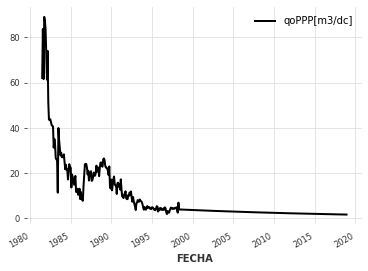

In [11]:
col = 'qoPPP[m3/dc]'
data_ts[col].plot()

## Filtramos y tomamos el intervalo a analizar

component  qoPPP[m3/dc]  qoPPP[m3/dc]
count        176.000000     46.000000
mean          19.461368      3.951232
std           16.427328      0.770066
min            3.080650      1.943330
25%            8.524197      3.786783
50%           16.697955      3.893080
75%           23.337180      4.282900
max           89.035480      6.993330


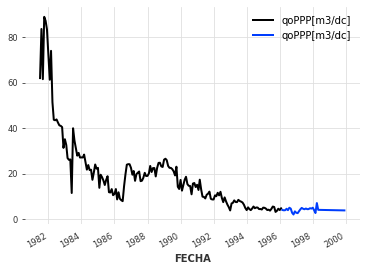

In [13]:
valid_ts = data_ts.drop_after(pd.Timestamp('2000-01-01'))
train, test = valid_ts[col].split_before(0.8)
print(pd.concat([train.describe(), test.describe()], axis =1))
train.plot(); test.plot()

## Modelos a utilizar

In [14]:
model0 = Theta(seasonality_period = 24)
model1 = LinearRegressionModel(lags =24)
model2 = ExponentialSmoothing(seasonal_periods = 24)
model3 = ARIMA(p=12, d=1, q=24)
model4 = RandomForest(lags =24, n_estimators = 300)


models = {
    'Theta': model0,
    'Linear': model1,
    'Exponencial': model2,
    'ARIMA': model3,
    'RandomForest': model4
}

### Discriminamos modelos para determinar su ajuste con los datos

Theta
Linear
Exponencial
ARIMA
RandomForest


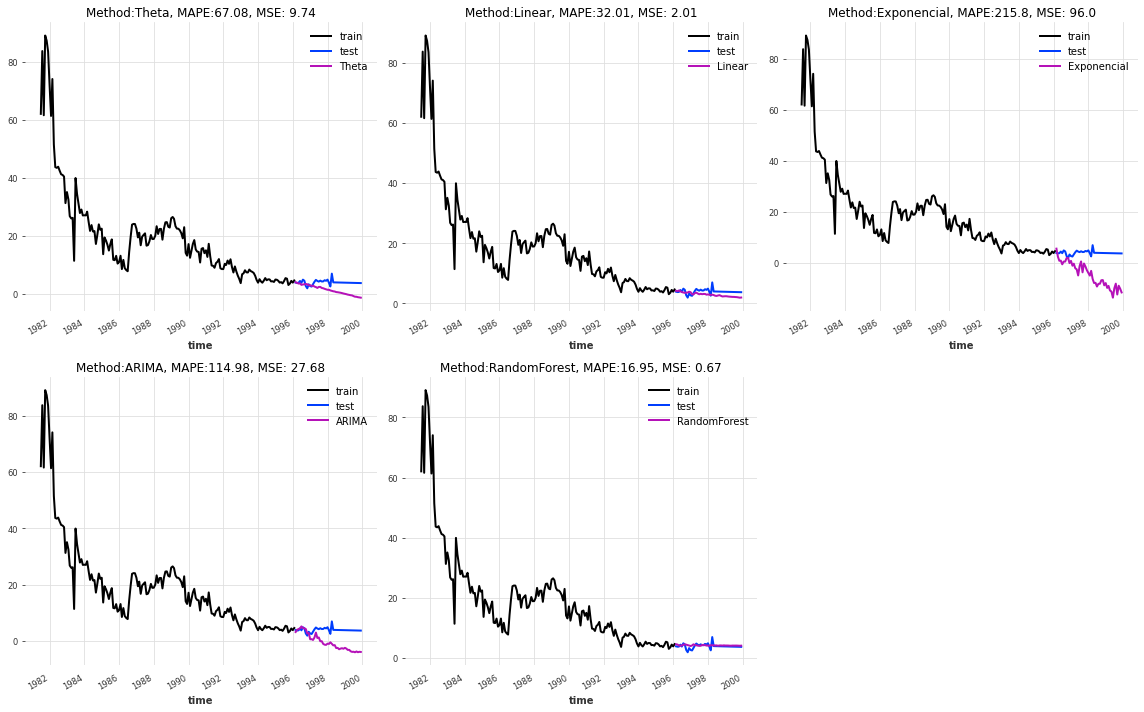

In [15]:
fig = plt.figure(figsize = (16, 10))
for i, (name, model) in enumerate(models.items()):
    print(name)
    model.fit(series = train)
    predictions = model.predict(n=len(test))
    mape_score = round(mape(test, predictions), 2)
    mse_score = round(mse(test, predictions), 2)
    
    fig.add_subplot(2, 3, i+1)
    train.plot(label = "train"); test.plot(label = "test"); predictions.plot(label = name)
    plt.title(f"Method:{name}, MAPE:{mape_score}, MSE: {mse_score}"); plt.legend()
fig.tight_layout()
plt.show()

Como podemos visualizar el modelo lineal y el de random forest, se ajustan mejor con los datos

## Aplicaremos un modelo de deep learning llamada N-BEATS

Para visualizar su ajuste con los corridos anteriormente

In [16]:
model5 = NBEATSModel(
    input_chunk_length = 24,
    output_chunk_length = 4,
    num_stacks = 3,
    num_blocks = 1,
    num_layers = 2,
    layer_widths = 32,
    n_epochs = 50, 
    batch_size = 12,
)

[2022-02-21 19:32:59,451] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 149 samples.
[2022-02-21 19:32:59,451] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 149 samples.
[2022-02-21 19:32:59,529] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-21 19:32:59,529] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


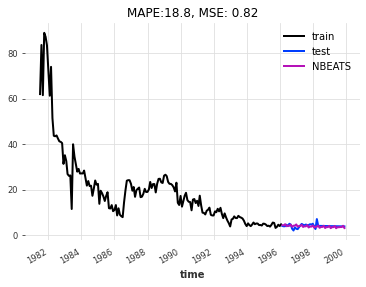

In [17]:
model5.fit(series = train)
predictions = model5.predict(n = len(test))
mape_score = round(mape(test, predictions), 2)
mse_score = round(mse(test, predictions), 2)

train.plot(label = "train"); test.plot(label = "test"); predictions.plot(label = 'NBEATS')
plt.title(f"MAPE:{mape_score}, MSE: {mse_score}"); plt.legend(); plt.show()


Como se puede apreciar, ajusta casi similar al de random foprest